# Test finding conserved quantities in simple integrable models 
E.g. harmonic oscillator, Kepler, Neumann

## Settings

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
tfe = tf.contrib.eager
import tensorflow_probability as tfp
tfd = tfp.distributions
import sys
sys.path.append("../")

#from IPython import display
#import imageio
#import glob
#import os

In [2]:
from models import *
from hamiltonians import harmonic_oscillator, kepler, parameterized_neumann
from utils import join_q_p, BaseDistributionNormal, BaseDistributionActionAngle, BaseDistributionIntegralsOfMotion
from utils import visualize_chain_bijector, extract_q_p, join_q_p, is_symplectic, normsq_nobatch
from losses import make_loss

In [3]:
# tf.enable_eager_execution()
sess = tf.InteractiveSession()
#from tensorflow.python import debug as tf_debug
#sess = tf_debug.TensorBoardDebugWrapperSession(sess, 'localhost:6064')

In [4]:
tf.set_random_seed(0)

In [5]:
# Suppress the warning till they fix this:
# lib/python3.5/site-packages/tensorflow/python/util/tf_inspect.py:75: 
# DeprecationWarning: inspect.getargspec() is deprecated, use inspect.signature() instead
import warnings
warnings.filterwarnings("ignore")

In [6]:
DTYPE=tf.float32
NP_DTYPE=np.float32
settings = {
    'hamiltonian': harmonic_oscillator, #parameterized_neumann([.1,.2,.3]),
    'd': 1,               # space dimension
    'num_particles': 1,   # number of particles
    'batch_size': 256,    # Mini batch size 
    'num_bijectors': 4,   # Number of bijectors
    'train_iters': int(1e5), # Number of training iterations
    'log_dir' : "/tmp/log/im_tests/oscillator/",
    'infinite_batch': True,
    'visualize': True,
    'starter_learning_rate': 0.001, 
    'decay_lr': False,
    'decay_steps': 20000, # ignored if decay_lr False
    'decay_rate': 0.75}   # ignored if decay_lr False

Define the model as sequence of a symplectic transformation T 

In [7]:
# Map the first pair psi, F to oscillator coordinates

# T = Chain([OscillatorFlow(first_only=True)] + 
#           [SymplecticAdditiveCoupling(shift_model=MLP()) if i % 2 == 0 
#            else LinearSymplecticTwoByTwo() 
#            for i in range(settings['num_bijectors'])])

T = Chain([SymplecticAdditiveCoupling(shift_model=MLP(activation=tf.nn.softplus)) if i % 2 == 0 
           else LinearSymplecticTwoByTwo() 
           for i in range(settings['num_bijectors'])])

# T = HamiltonianFlow( MLPHamiltonian(), initial_t=0., final_t=1., num_steps=100 ) 

# class myf(tf.keras.Model):
#     def __init__(self):
#         super(myf, self).__init__()
#         d = 512
#         activation = tf.nn.softplus
#         self.dense1 = tf.keras.layers.Dense(d, activation=activation)
#         self.dense2 = tf.keras.layers.Dense(1, activation=activation)
    
#     def call(self, z):
#         z_shape = tf.shape(z)
#         z = tf.exp( self.dense2( self.dense1(tf.layers.flatten(z)) ) )
#         return tf.reshape(z, z_shape)
    
#     def inverse(self, z):
#         z_shape = tf.shape(z)
#         z = tf.exp( - self.dense2( self.dense1(tf.layers.flatten(z)) ) )
#         return tf.reshape(z, z_shape)    
    
# T = Chain([NonLinearSqueezing(myf()),
#            SymplecticAdditiveCoupling(shift_model=MLP()),
#            LinearSymplecticTwoByTwo(),
#            NonLinearSqueezing(myf()),
#            SymplecticAdditiveCoupling(shift_model=MLP()),
#            LinearSymplecticTwoByTwo() ])

Data and loss

In [8]:
with tf.name_scope("sampler"):    
    sh = [settings['d'], settings['num_particles'], 2]
    # Take cube of side scale
    scale = 5.
    sampler = tfd.Independent(tfd.Uniform(low=0. * tf.ones(sh, DTYPE),
                                          high=scale * tf.ones(sh, DTYPE)),
                              reinterpreted_batch_ndims=len(sh))
    z = sampler.sample(settings['batch_size'])
    if not settings['infinite_batch']:
        # Fixed batch. Every iteration gets exactly the same data
        z = tf.constant(sess.run(z)) 

# If conserved_radii, sample both positive and negative values
loss = make_loss(settings, T, z, "K_equal_action_H")

## Training options

In [9]:
with tf.name_scope("train"):    
    step = tf.get_variable("global_step", [], tf.int64, tf.zeros_initializer(), trainable=False)   
    starter_learning_rate = settings['starter_learning_rate']
    if settings['decay_lr']:
        min_learning_rate = 1e-7
        learning_rate = tf.train.exponential_decay(starter_learning_rate, step, settings['decay_steps'], 
                                                   settings['decay_rate'], staircase=True)
        learning_rate = tf.maximum(learning_rate, min_learning_rate) # clip
    else:
        learning_rate = starter_learning_rate
    optimiser = tf.train.AdamOptimizer(learning_rate)
    gradients = optimiser.compute_gradients(loss=loss)
    if settings['visualize']:
        for gradient, variable in gradients:
            tf.summary.scalar("gradients/" + variable.name.replace(':','_'), tf.norm(gradient))
            tf.summary.scalar("variable/" + variable.name.replace(':','_'), tf.norm(variable))
    train_op = optimiser.apply_gradients(gradients, global_step=step)

In [10]:
# tensorboard
#merged = tf.summary.merge_all()
#writer = tf.summary.FileWriter(settings['log_dir'], sess.graph)

In [11]:
sess.run(tf.global_variables_initializer())

### Visualize before training

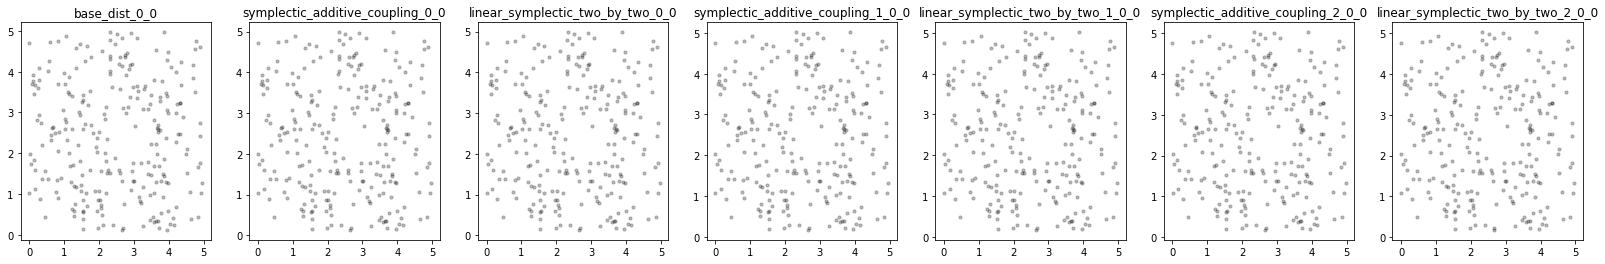

In [12]:
visualize_chain_bijector(T, z, sess=sess)

## Train

In [10]:
tf.contrib.training.train(train_op, logdir=settings['log_dir'], save_checkpoint_secs=60)

INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 0 into /tmp/log/im_tests/oscillator/model.ckpt.
INFO:tensorflow:global_step/sec: 168.274
INFO:tensorflow:global_step/sec: 326.141
INFO:tensorflow:global_step/sec: 358.261
INFO:tensorflow:global_step/sec: 336.016
INFO:tensorflow:global_step/sec: 363.555
INFO:tensorflow:global_step/sec: 384.6
INFO:tensorflow:global_step/sec: 329.461
INFO:tensorflow:global_step/sec: 367.196
INFO:tensorflow:global_step/sec: 368.863
INFO:tensorflow:global_step/sec: 355.507
INFO:tensorflow:global_step/sec: 370.001
INFO:tensorflow:global_step/sec: 386.008
INFO:tensorflow:global_step/sec: 361.22
INFO:tensorflow:global_step/sec: 345.059
INFO:tensorflow:global_step/sec: 373.97
INFO:tensorflow:global_step/sec: 342.684
INFO:tensorflow:global_step/sec: 317.99
INFO:tensorflow:global_step/sec: 359.894
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 357.126
INFO:tensorflow:global_step/sec: 392.62
INFO:tensorflow:global_step/sec: 372.154
INFO:tensorflow:global_step/sec: 348.114
INFO:tensorflow:global_step/sec: 384.86
INFO:tensorflow:global_step/sec: 375.566
INFO:tensorflow:global_step/sec: 356.565
INFO:tensorflow:global_step/sec: 338.062
INFO:tensorflow:global_step/sec: 351.829
INFO:tensorflow:global_step/sec: 368.314
INFO:tensorflow:global_step/sec: 379.1
INFO:tensorflow:global_step/sec: 338.057
INFO:tensorflow:global_step/sec: 356.068
INFO:tensorflow:global_step/sec: 375.342
INFO:tensorflow:global_step/sec: 385.602
INFO:tensorflow:global_step/sec: 352.037
INFO:tensorflow:global_step/sec: 375.087
INFO:tensorflow:global_step/sec: 361.908
INFO:tensorflow:global_step/sec: 378.765
INFO:tensorflow:Saving checkpoints for 21498 into /tmp/log/im_tests/oscillator/model.ckpt.
INFO:tensorflow:global_step/sec: 249.678
INFO:tensorflow:global_step/sec: 372.739
INFO:tensorflow:global_step/sec: 366.484
INFO:tensor

INFO:tensorflow:global_step/sec: 319.812
INFO:tensorflow:global_step/sec: 360.116
INFO:tensorflow:global_step/sec: 369.484
INFO:tensorflow:global_step/sec: 358.752
INFO:tensorflow:global_step/sec: 372.46
INFO:tensorflow:global_step/sec: 357.33
INFO:tensorflow:global_step/sec: 367.53
INFO:tensorflow:global_step/sec: 355.465
INFO:tensorflow:global_step/sec: 377.266
INFO:tensorflow:global_step/sec: 353.161
INFO:tensorflow:global_step/sec: 369.855
INFO:tensorflow:global_step/sec: 365.784
INFO:tensorflow:global_step/sec: 353.944
INFO:tensorflow:global_step/sec: 366.04
INFO:tensorflow:global_step/sec: 368.339
INFO:tensorflow:global_step/sec: 377.338
INFO:tensorflow:global_step/sec: 354.725
INFO:tensorflow:global_step/sec: 349.108
INFO:tensorflow:global_step/sec: 357.024
INFO:tensorflow:global_step/sec: 312.498
INFO:tensorflow:global_step/sec: 354.262
INFO:tensorflow:global_step/sec: 306.701
INFO:tensorflow:global_step/sec: 326.942
INFO:tensorflow:global_step/sec: 356.545
INFO:tensorflow:glob

INFO:tensorflow:global_step/sec: 373.434
INFO:tensorflow:global_step/sec: 384.326
INFO:tensorflow:global_step/sec: 348.084
INFO:tensorflow:global_step/sec: 360.527
INFO:tensorflow:global_step/sec: 376.365
INFO:tensorflow:global_step/sec: 314.067
INFO:tensorflow:global_step/sec: 315.93
INFO:tensorflow:global_step/sec: 379.673
INFO:tensorflow:global_step/sec: 358.899
INFO:tensorflow:global_step/sec: 384.343
INFO:tensorflow:global_step/sec: 382.792
INFO:tensorflow:global_step/sec: 370.443
INFO:tensorflow:global_step/sec: 369.767
INFO:tensorflow:global_step/sec: 339.617
INFO:tensorflow:global_step/sec: 346.052
INFO:tensorflow:global_step/sec: 349.205
INFO:tensorflow:global_step/sec: 316.167
INFO:tensorflow:global_step/sec: 364.823
INFO:tensorflow:global_step/sec: 355.996
INFO:tensorflow:global_step/sec: 392.262
INFO:tensorflow:global_step/sec: 351.656
INFO:tensorflow:global_step/sec: 378.024
INFO:tensorflow:global_step/sec: 367.693
INFO:tensorflow:global_step/sec: 366.157
INFO:tensorflow:g

INFO:tensorflow:global_step/sec: 352.988
INFO:tensorflow:global_step/sec: 374.871
INFO:tensorflow:global_step/sec: 368.603
INFO:tensorflow:global_step/sec: 386.789
INFO:tensorflow:global_step/sec: 370.007
INFO:tensorflow:global_step/sec: 361.875
INFO:tensorflow:global_step/sec: 350.377
INFO:tensorflow:global_step/sec: 358.273
INFO:tensorflow:global_step/sec: 371.207
INFO:tensorflow:global_step/sec: 387.071
INFO:tensorflow:global_step/sec: 329.523
INFO:tensorflow:global_step/sec: 334.457
INFO:tensorflow:global_step/sec: 356.265
INFO:tensorflow:global_step/sec: 344.738
INFO:tensorflow:global_step/sec: 353.97
INFO:tensorflow:global_step/sec: 354.78
INFO:tensorflow:global_step/sec: 374.074
INFO:tensorflow:global_step/sec: 364.006
INFO:tensorflow:global_step/sec: 384.141
INFO:tensorflow:global_step/sec: 374.656
INFO:tensorflow:global_step/sec: 358.796
INFO:tensorflow:global_step/sec: 342.409
INFO:tensorflow:global_step/sec: 358.04
INFO:tensorflow:global_step/sec: 383.663
INFO:tensorflow:glo

INFO:tensorflow:global_step/sec: 366.438
INFO:tensorflow:global_step/sec: 320.204
INFO:tensorflow:global_step/sec: 338.725
INFO:tensorflow:global_step/sec: 360.777
INFO:tensorflow:global_step/sec: 362.219
INFO:tensorflow:global_step/sec: 374.227
INFO:tensorflow:global_step/sec: 391.838
INFO:tensorflow:global_step/sec: 337.379
INFO:tensorflow:global_step/sec: 369.65
INFO:tensorflow:global_step/sec: 387.341
INFO:tensorflow:global_step/sec: 368.712
INFO:tensorflow:global_step/sec: 351.731
INFO:tensorflow:global_step/sec: 373.257
INFO:tensorflow:global_step/sec: 379.566
INFO:tensorflow:global_step/sec: 380.371
INFO:tensorflow:global_step/sec: 379.811
INFO:tensorflow:global_step/sec: 369.484
INFO:tensorflow:global_step/sec: 348.224
INFO:tensorflow:global_step/sec: 348.209
INFO:tensorflow:global_step/sec: 353.098
INFO:tensorflow:global_step/sec: 346.626
INFO:tensorflow:global_step/sec: 356.94
INFO:tensorflow:global_step/sec: 361.722
INFO:tensorflow:global_step/sec: 372.501
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 376.509
INFO:tensorflow:global_step/sec: 384.541
INFO:tensorflow:global_step/sec: 360.893
INFO:tensorflow:global_step/sec: 394.923
INFO:tensorflow:global_step/sec: 363.643
INFO:tensorflow:global_step/sec: 382.494
INFO:tensorflow:global_step/sec: 376.766
INFO:tensorflow:global_step/sec: 358.088
INFO:tensorflow:global_step/sec: 366.833
INFO:tensorflow:global_step/sec: 370.555
INFO:tensorflow:global_step/sec: 337.832
INFO:tensorflow:global_step/sec: 361.329
INFO:tensorflow:global_step/sec: 384.778
INFO:tensorflow:global_step/sec: 337.733
INFO:tensorflow:global_step/sec: 379.877
INFO:tensorflow:global_step/sec: 356.486
INFO:tensorflow:global_step/sec: 364.955
INFO:tensorflow:global_step/sec: 362.069
INFO:tensorflow:global_step/sec: 342.542
INFO:tensorflow:global_step/sec: 359.373
INFO:tensorflow:global_step/sec: 372.022
INFO:tensorflow:global_step/sec: 351.769
INFO:tensorflow:global_step/sec: 333.637
INFO:tensorflow:global_step/sec: 372.122
INFO:tensorflow:

INFO:tensorflow:global_step/sec: 387.177
INFO:tensorflow:global_step/sec: 366.505
INFO:tensorflow:global_step/sec: 290.075
INFO:tensorflow:global_step/sec: 353.98
INFO:tensorflow:global_step/sec: 372.181
INFO:tensorflow:global_step/sec: 336.928
INFO:tensorflow:global_step/sec: 335.669
INFO:tensorflow:global_step/sec: 355.292
INFO:tensorflow:global_step/sec: 363.157
INFO:tensorflow:global_step/sec: 341.623
INFO:tensorflow:global_step/sec: 348.142
INFO:tensorflow:global_step/sec: 369.958
INFO:tensorflow:global_step/sec: 363.939
INFO:tensorflow:global_step/sec: 362.464
INFO:tensorflow:global_step/sec: 353.571
INFO:tensorflow:global_step/sec: 384.193
INFO:tensorflow:global_step/sec: 356.353
INFO:tensorflow:global_step/sec: 364.262
INFO:tensorflow:global_step/sec: 348.815
INFO:tensorflow:global_step/sec: 363.709
INFO:tensorflow:global_step/sec: 353.283
INFO:tensorflow:global_step/sec: 378.671
INFO:tensorflow:global_step/sec: 346.733
INFO:tensorflow:global_step/sec: 354.574
INFO:tensorflow:g

INFO:tensorflow:global_step/sec: 368.894
INFO:tensorflow:global_step/sec: 363.434
INFO:tensorflow:global_step/sec: 368.47
INFO:tensorflow:global_step/sec: 374.204
INFO:tensorflow:global_step/sec: 361.215
INFO:tensorflow:global_step/sec: 361.976
INFO:tensorflow:global_step/sec: 365.463
INFO:tensorflow:global_step/sec: 359.926
INFO:tensorflow:global_step/sec: 364.047
INFO:tensorflow:global_step/sec: 366.105
INFO:tensorflow:global_step/sec: 365.137
INFO:tensorflow:global_step/sec: 385.465
INFO:tensorflow:global_step/sec: 391.385
INFO:tensorflow:global_step/sec: 361.337
INFO:tensorflow:global_step/sec: 368.934
INFO:tensorflow:global_step/sec: 362.609
INFO:tensorflow:global_step/sec: 358.945
INFO:tensorflow:global_step/sec: 391.537
INFO:tensorflow:global_step/sec: 387.656
INFO:tensorflow:global_step/sec: 372.469
INFO:tensorflow:global_step/sec: 383.566
INFO:tensorflow:global_step/sec: 354.908
INFO:tensorflow:global_step/sec: 340.095
INFO:tensorflow:global_step/sec: 365.006
INFO:tensorflow:g

INFO:tensorflow:global_step/sec: 379.471
INFO:tensorflow:global_step/sec: 371.533
INFO:tensorflow:global_step/sec: 366.884
INFO:tensorflow:global_step/sec: 361.35
INFO:tensorflow:global_step/sec: 381.344
INFO:tensorflow:global_step/sec: 382.548
INFO:tensorflow:global_step/sec: 374.373
INFO:tensorflow:global_step/sec: 394.046
INFO:tensorflow:global_step/sec: 327.097
INFO:tensorflow:global_step/sec: 335.841
INFO:tensorflow:global_step/sec: 371.622
INFO:tensorflow:global_step/sec: 365.016
INFO:tensorflow:global_step/sec: 388.47
INFO:tensorflow:global_step/sec: 379.31
INFO:tensorflow:global_step/sec: 361.5
INFO:tensorflow:global_step/sec: 361.852
INFO:tensorflow:global_step/sec: 335.964
INFO:tensorflow:global_step/sec: 356.142
INFO:tensorflow:global_step/sec: 374.173
INFO:tensorflow:global_step/sec: 350.827
INFO:tensorflow:global_step/sec: 373.636
INFO:tensorflow:global_step/sec: 380.828
INFO:tensorflow:global_step/sec: 363.975
INFO:tensorflow:global_step/sec: 354.875
INFO:tensorflow:globa

INFO:tensorflow:global_step/sec: 391.461
INFO:tensorflow:global_step/sec: 361.28
INFO:tensorflow:global_step/sec: 372.551
INFO:tensorflow:global_step/sec: 386.922
INFO:tensorflow:global_step/sec: 367.846
INFO:tensorflow:global_step/sec: 371.079
INFO:tensorflow:global_step/sec: 355.206
INFO:tensorflow:global_step/sec: 382.333
INFO:tensorflow:global_step/sec: 382.29
INFO:tensorflow:global_step/sec: 391.989
INFO:tensorflow:global_step/sec: 366.841
INFO:tensorflow:global_step/sec: 379.816
INFO:tensorflow:global_step/sec: 388.027
INFO:tensorflow:global_step/sec: 385.285
INFO:tensorflow:global_step/sec: 367.311
INFO:tensorflow:global_step/sec: 377.229
INFO:tensorflow:global_step/sec: 376.423
INFO:tensorflow:global_step/sec: 379.558
INFO:tensorflow:global_step/sec: 351.354
INFO:tensorflow:global_step/sec: 355.485
INFO:tensorflow:global_step/sec: 367.413
INFO:tensorflow:global_step/sec: 351.818
INFO:tensorflow:global_step/sec: 354.455
INFO:tensorflow:global_step/sec: 353.823
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 370.241
INFO:tensorflow:global_step/sec: 344.927
INFO:tensorflow:global_step/sec: 350.317
INFO:tensorflow:global_step/sec: 348.284
INFO:tensorflow:global_step/sec: 360.883
INFO:tensorflow:global_step/sec: 363.257
INFO:tensorflow:global_step/sec: 359.753
INFO:tensorflow:global_step/sec: 338.585
INFO:tensorflow:global_step/sec: 345.468
INFO:tensorflow:global_step/sec: 387.069
INFO:tensorflow:global_step/sec: 366.849
INFO:tensorflow:global_step/sec: 369.809
INFO:tensorflow:global_step/sec: 376.627
INFO:tensorflow:global_step/sec: 370.718
INFO:tensorflow:global_step/sec: 368.985
INFO:tensorflow:global_step/sec: 386.45
INFO:tensorflow:global_step/sec: 380.202
INFO:tensorflow:global_step/sec: 365.72
INFO:tensorflow:global_step/sec: 360.315
INFO:tensorflow:global_step/sec: 328.594
INFO:tensorflow:global_step/sec: 374.544
INFO:tensorflow:global_step/sec: 395.446
INFO:tensorflow:global_step/sec: 336.794
INFO:tensorflow:global_step/sec: 372.167
INFO:tensorflow:gl

INFO:tensorflow:global_step/sec: 350.559
INFO:tensorflow:global_step/sec: 369.544
INFO:tensorflow:global_step/sec: 383.874
INFO:tensorflow:global_step/sec: 343.3
INFO:tensorflow:global_step/sec: 353.228
INFO:tensorflow:global_step/sec: 325.436
INFO:tensorflow:global_step/sec: 369.927
INFO:tensorflow:global_step/sec: 395.98
INFO:tensorflow:global_step/sec: 391.353
INFO:tensorflow:global_step/sec: 378.742
INFO:tensorflow:global_step/sec: 386.899
INFO:tensorflow:global_step/sec: 381.611
INFO:tensorflow:global_step/sec: 379.688
INFO:tensorflow:global_step/sec: 366.57
INFO:tensorflow:global_step/sec: 369.352
INFO:tensorflow:global_step/sec: 371.727
INFO:tensorflow:global_step/sec: 280.156
INFO:tensorflow:global_step/sec: 278.833
INFO:tensorflow:global_step/sec: 329.409
INFO:tensorflow:global_step/sec: 348.78
INFO:tensorflow:global_step/sec: 360.463
INFO:tensorflow:global_step/sec: 359.427
INFO:tensorflow:global_step/sec: 351.038
INFO:tensorflow:global_step/sec: 371.771
INFO:tensorflow:globa

KeyboardInterrupt: 

In [14]:
# def generate_and_save_images(model, epoch, test_input):
#     predictions = model(test_input)
# #    fig = plt.figure(figsize=(4,4))
#     fig = plt.figure()
#     visualize_chain_bijector(model, z_samples, sess=sess)
#     plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
#     plt.show()

In [14]:
# np_losses = []
# for i in range(int(settings['train_iters'])):
#     _, np_loss, np_K = sess.run([train_op, loss, tf.reduce_mean(K)])
#     if i % 1 == 0:
# #        summary,it = sess.run([merged,step])
# #        writer.add_summary(summary, it)
#         print('loss at step %s: %s, K: %s' % (i, np_loss, np_K))

In [13]:
writer.close()

In [17]:
# Load the latest parameters
saver = tf.train.Saver()
ckpt_state = tf.train.get_checkpoint_state(settings['log_dir'])
saver.restore(sess, ckpt_state.model_checkpoint_path)

INFO:tensorflow:Restoring parameters from /tmp/log/im_tests/kepler_2/model.ckpt-106191


In [19]:
# Test accuracy on new minibatch
print("Test error: ", sess.run(loss))

Test error:  0.00078132283


In [24]:
is_symplectic( T, tf.random_normal([1,settings['d'],settings['num_particles'],2]), sess=sess, rtol=1e-05, atol=1e-04 )

True

### Visualize after training

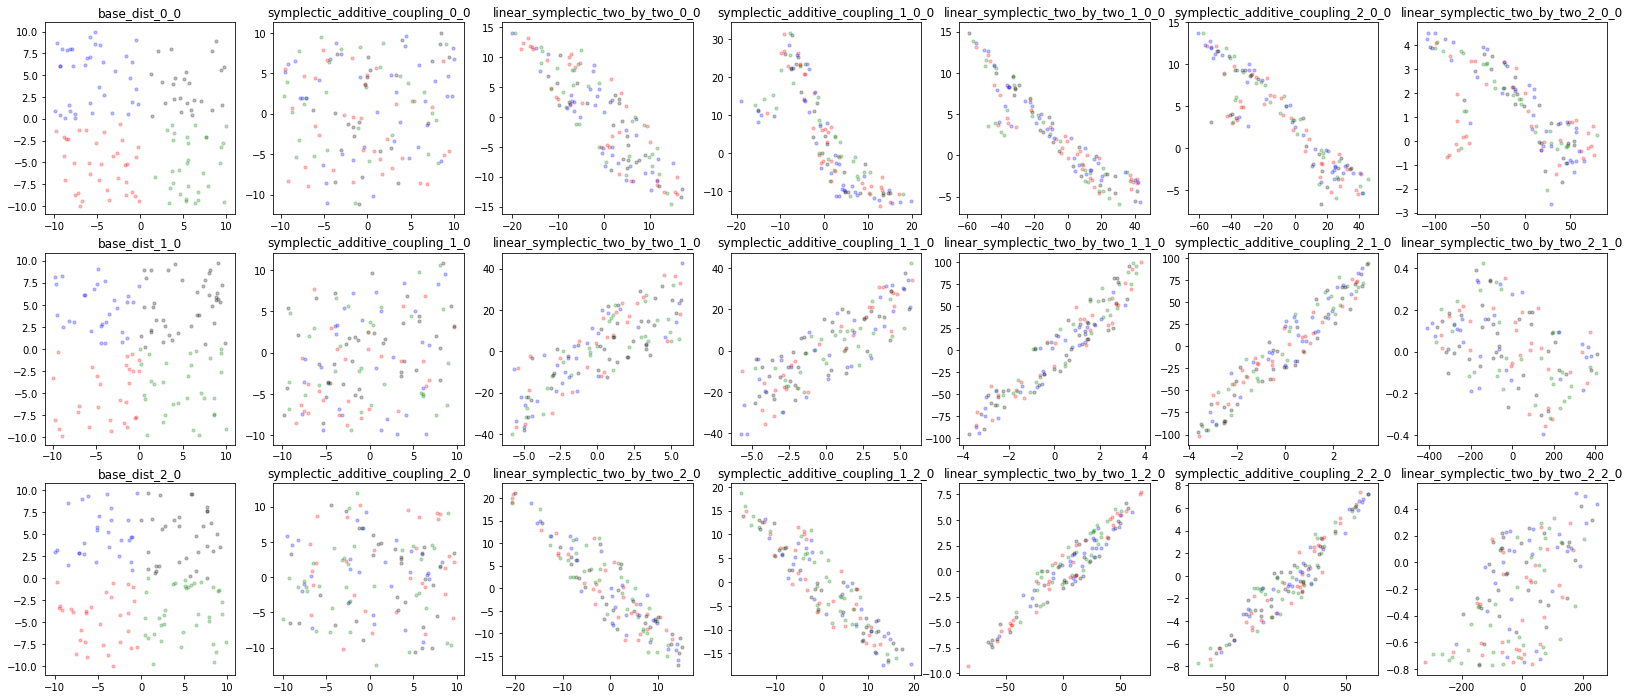

In [25]:
zz = tf.random_uniform([128,3,1,2],minval=-10,maxval=10)
visualize_chain_bijector(T, zz, sess=sess)
#visualize_chain_bijector(T, z, sess=sess)

Look more closely at where (thick) lines F ~ const, psi = t are sent:

(512,)


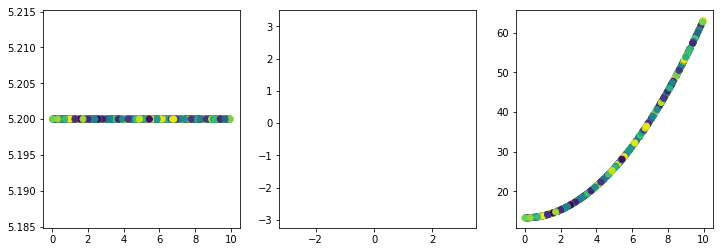

In [18]:
N = 512
psis = tf.random_uniform([N,1,1,1], minval=0., maxval=10., dtype=DTYPE)
Fs = tf.ones([N,1,1,1], dtype=DTYPE) * 5.2
line = join_q_p(psis, Fs)
mapped_line = T(line)
#mapped_line = T.bijectors[0](line)
H_on_line = settings['hamiltonian']( mapped_line )
line_np, mapped_line_np, H_on_line_np = sess.run([line, mapped_line, H_on_line])
print(H_on_line_np.shape)

colors = np.random.rand(N)

fig, axes = plt.subplots(1, 3, figsize=(4 * 3, 4 * 1))
axes[0].scatter(line_np[:,0,0,0],line_np[:,0,0,1],c=colors)
axes[1].scatter(mapped_line_np[:,0,0,0],mapped_line_np[:,0,0,1],c=colors)
axes[1].set_xlim(-3.25, 3.5)
axes[1].set_ylim(-3.25, 3.5)
axes[2].scatter(line_np[:,0,0,0],H_on_line_np,c=colors)

In [33]:
import numpy as np
np.sqrt(2 * 5.2)

3.22490309931942

In [77]:
X = np.array([9., 6.])
Y = np.array([22., 23.])
.5 * ( X**2 + Y**2 )

array([282.5, 282.5])

Note: H on the line is almost constant, higher curvature where T has higher curvature (middle).

The energy is 282.5 which correponds to a radius of sqrt(q^2 + p^2) = sqrt(2E) ~ 24. This is the square of the value of F! 

Note, given I,phi action-angle for the oscillator, so that q = sqrt(2I) cos(phi) , p = sqrt(2I) sin(phi), one can always rescale I -> F = s I, phi -> psi = phi / s, so that the period of psi is 2 pi s, and if E=I, F = s E. This leads to a family of action-angle variables parameterized by s. To fix the scale, we need to set the periodicity of psi. Namely, we need that the canonical transformation is multivalued with period 2pi. In fact, we know phi = arctan(q/p) which is a multivalued function, because tan is 2pi periodic. 

In action-angle theory, the scale of phi is set by demanding integral over the cycle to be 2pi.









Why the mapped line q,p has constant energy for the harmonic oscillator?


Interpretation: fixed F and varying psi (horizontal line) is sent to roughly a point on the right. Different lines are sent to different points on the (thick) line on the right. This removes psi dependence from T(z) -> roughly d T(F,psi)/d psi = 0. This clearly implies d H(T(F,psi)) / d psi = d H / d T * d T / d psi = 0.

Below indeed we confirm this, seeing that the transformed Hamiltonian depends only on the actions F, as roughly K = H circ T = sgn(F).

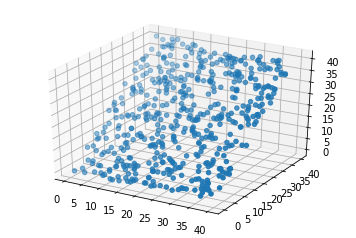

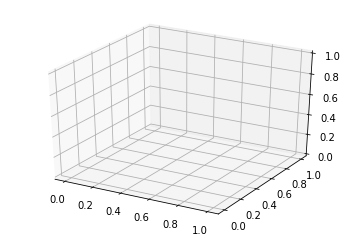

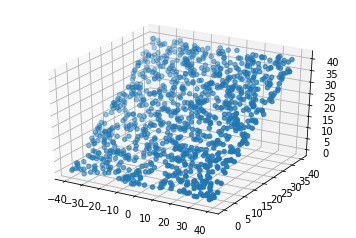

In [20]:
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs, ys = sess.run( extract_q_p( tf.random_uniform((512,1,1,2), minval=0., maxval=40.) ) )
zs = sess.run( settings['hamiltonian']( T ( join_q_p(xs,ys) ) ) )
ax.scatter(xs, ys, zs)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs, ys = sess.run( extract_q_p( tf.random_uniform((512,1,1,2), minval=-40., maxval=0.) ) )
zs = sess.run( settings['hamiltonian']( T ( join_q_p(xs,ys) ) ) )
ax.scatter(xs, ys, zs)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
xs, ys = sess.run( extract_q_p( tf.random_uniform((2048,1,1,2), minval=-40., maxval=40.) ) )
zs = sess.run( settings['hamiltonian']( T ( join_q_p(xs,ys) ) ) )
ax.scatter(xs, ys, zs)

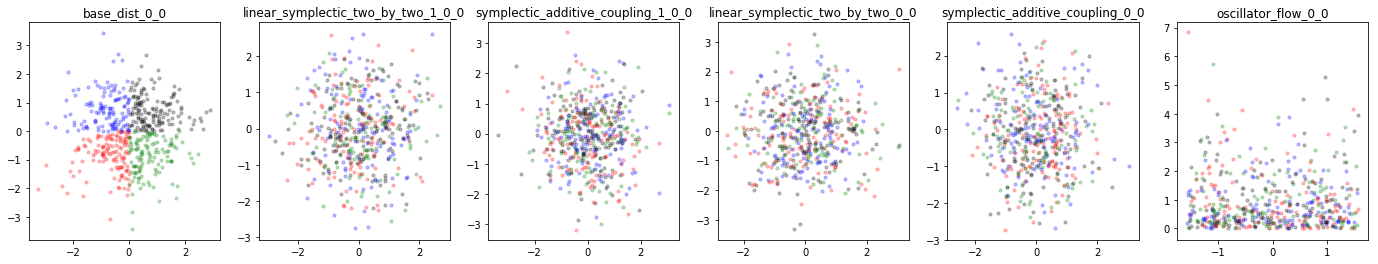

In [21]:
import utils
from importlib import reload
reload(utils)
x = tf.random_normal([512,1,1,2])
utils.visualize_chain_bijector(T, x, sess=sess, inverse=True)

## Look at the Learned Representation

Try directly integrating the eom of the transformed Hamiltonian

In [27]:
# Use HamiltonianFlow as integrator of Hamiltonian
integrator = HamiltonianFlow(lambda z : settings['hamiltonian'](T(z)),
                             initial_t=0., 
                             final_t=10., 
                             num_steps=1000)
# 1 random initial condition (scale it back so that the motion is in the sampled region)
x0 = sess.run( sampler.sample(1) * 1/scale )
print(x0)
#x0 = tf.reshape([1.,0.2,1.,0.3,1.,0.4],[1,3,1,2])

[[[[0.13735282 0.06811118]]

  [[0.84217346 0.41552028]]

  [[0.837504   0.5293603 ]]]]


In [28]:
traj = sess.run( integrator(x0, return_full_state=True) )
# traj has shape (time,batch,d,n,2) Here batch trivial, squeeze it out, so that time becomes batch
traj = np.squeeze(traj, 1)
qtraj, ptraj = extract_q_p( traj )

Visualize: the transformed trajectories

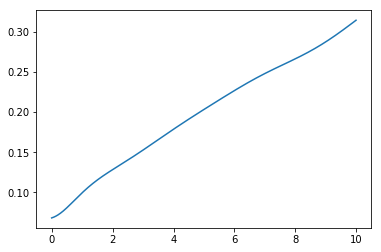

In [33]:
ts = np.arange(0.,10.,.01)
# rhotraj = np.sum( qtraj**2 + ptraj**2 , (1,2,3) )
# plt.plot(ts, rhotraj)

plt.plot(ts, ptraj[:,0,0,0])

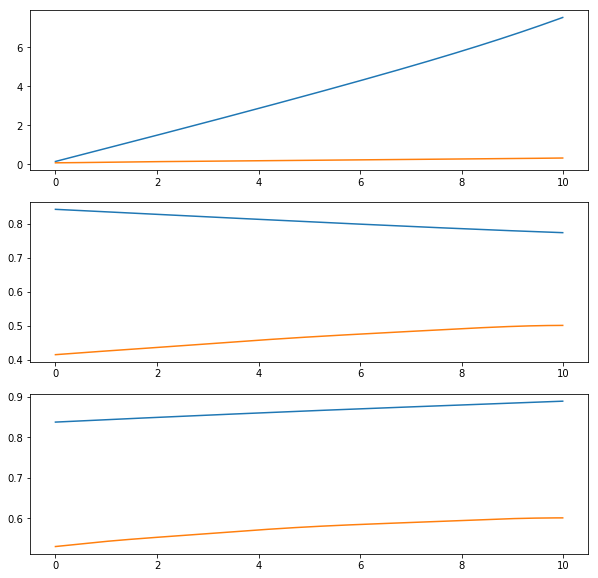

In [31]:
plt.figure(figsize=(10,10))

for d in range(settings['d']):
    for n in range(settings['num_particles']):
        plt.subplot(settings['d'], settings['num_particles'], d * settings['num_particles'] + n + 1)
        #plt.plot(qtraj[:,d,n,0], ptraj[:,d,n,0])
        plt.plot(ts, qtraj[:,d,n,0])
        plt.plot(ts, ptraj[:,d,n,0])
        #plt.gca().set_aspect('equal', adjustable='box')

Pretty good till 20, the error is small. The it gets bad...why? Is it a problem with the learning (unable to generalize) or with the integration? Anyway, improving...

TODO: Trajectories of original Hamiltonian

In [93]:
# Use HamiltonianFlow as integrator of Hamiltonian

def myH(x):
    q,p = extract_q_p(x)
    eps = 1e-5
    r = tf.sqrt(tf.reduce_sum(tf.square(q), axis=1) + eps)
    V = 1.0 / r
    return tf.squeeze(0.5 * tf.reduce_sum(tf.square(p), axis=1) + V)

integrator = HamiltonianFlow(settings['hamiltonian'],
                             initial_t=0., 
                             final_t=10., 
                             num_steps=1000)
# 1 random initial condition 
#x0 = sess.run( T( sampler.sample(1) ) )
#print(x0)
x0 = tf.reshape([.1, 0.2, .2, 0.2, .3, 0.2] ,[1,3,1,2])
q0,p0 = extract_q_p(x0)
print(q0.eval(), p0.eval())

[[[[0.1]]

  [[0.2]]

  [[0.3]]]] [[[[0.2]]

  [[0.2]]

  [[0.2]]]]


In [94]:
traj = sess.run( integrator(x0, return_full_state=True) )
# traj has shape (time,batch,d,n,2) Here batch trivial, squeeze it out, so that time becomes batch
traj = np.squeeze(traj, 1)
xtraj, ytraj = extract_q_p( traj )

Transformed trajectories

In [95]:
trans_traj = sess.run(T.inverse(traj))
qtraj, ptraj = extract_q_p(trans_traj)

Visualize: the transformed trajectories should be circles so that their radius is a constant of the motion

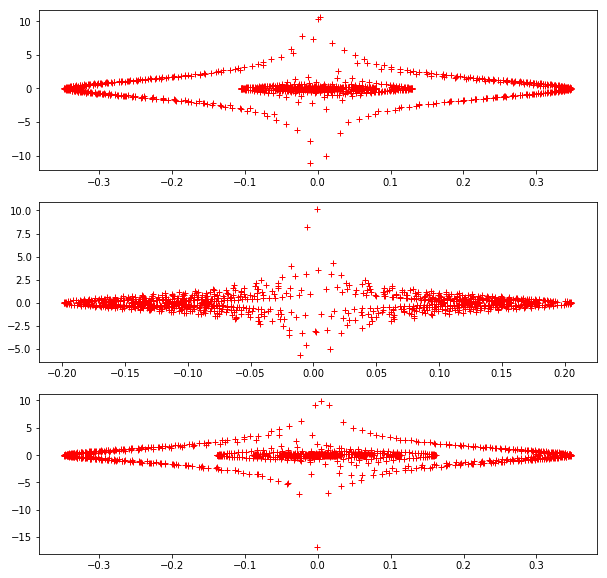

In [96]:
plt.figure(figsize=(10,10))

for d in range(settings['d']):
    for n in range(settings['num_particles']):
        plt.subplot(settings['d'], settings['num_particles'], d * settings['num_particles'] + n + 1)
        plt.plot(xtraj[:,d,n,0], ytraj[:,d,n,0],'r+')
        #plt.plot(qtraj[:,d,n,0], ptraj[:,d,n,0])
        #plt.xlim(-10, 10)
        #plt.ylim(-10, 10)
        #plt.plot(ts, xtraj[:,d,n,0])
        #plt.plot(ts, ytraj[:,d,n,0])
        
#        plt.gca().set_aspect('equal', adjustable='box')